In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from docplex.cp.model import CpoModel
import numpy as np
import yaml

<IPython.core.display.Javascript object>

In [42]:
def load(path):
    with open(path) as fp:
        data = yaml.load(fp, Loader=yaml.CSafeLoader)

    pts = sorted(data["points"].keys())
    p2i = {k: i for i, k in enumerate(pts)}

    locks = [
        [data["points"][p].get("x-lock", False), data["points"][p].get("y-lock", False)]
        for p in pts
    ]

    points = [[data["points"][i]["x"], data["points"][i]["y"]] for i in pts]

    distances = {(p2i[d["from"]], p2i[d["to"]]): d["d"] for d in data["distances"]}

    return np.asarray(points), locks, distances

<IPython.core.display.Javascript object>

In [43]:
points, locks, distances = load("./terrasse.yml")

<IPython.core.display.Javascript object>

In [75]:
from IPython.display import clear_output

max_xy = 15000  # 15 meters

m = CpoModel()

x = np.asarray(
    [
        [
            m.integer_var(min=0, max=max_xy, name="x_{i}"),
            m.integer_var(min=0, max=max_xy, name="y_{i}"),
        ]
        for i in range(len(points))
    ]
)

dists = np.array(list(distances.values())) * 1000  # millimeters

expr_dists = np.sum(
    np.power(np.diff(x[list(distances.keys()), :], axis=1), 2), axis=-1
).squeeze()

epss_2 = [m.abs(e) for e in (expr_dists - np.power(dists, 2))]
epss = m.integer_var_list(len(epss_2), min=0, max=max_xy, name="e")

for eps, eps_2 in zip(epss, epss_2):
    m.add(eps * eps == eps_2)

# fix points
for i, (xlock, ylock) in enumerate(locks):
    if xlock:
        m.add(x[i, 0] == int(points[i, 0] * 1000))
    if ylock:
        m.add(x[i, 1] == int(points[i, 1] * 1000))

# test 1
# m.add(m.minimize(m.max(epss)))
# m.add(m.minimize(np.sum(epss)))
m.add(m.minimize_static_lex([m.max(epss), np.sum(epss)]))

m.set_search_phases(
    m.search_phase(
        list(x.flatten()),
        varchooser=m.select_random_var(),
        valuechooser=m.select_largest(lambda u, v: [max(u, v), min*u),
    )
)

for s in m.start_search(TimeLimit=600):
    u = np.array([[s[x[i][0]], s[x[i][1]]] for i in range(len(points))]) / 1000.0
    v = distances

    diffs = []
    for i, j in v:
        p = np.abs(np.sqrt(np.power(u[i] - u[j], 2).sum()) - v[i, j])
        diffs.append(p)

        # print(i, j, v[i, j], p)

    ndiffs = np.array(diffs)

    clear_output()
    print(
        "{}, min. = {}, max. = {}, sum. = {}".format(
            s.get_objective_values(), ndiffs.min(), ndiffs.max(), ndiffs.sum()
        )
    )

CpoException: Impossible to build a CP Optimizer expression with value '<function <lambda> at 0x000001615ECC1940>' of type '<class 'function'>'

<IPython.core.display.Javascript object>

In [56]:
u = np.array([[s[x[i][0]], s[x[i][1]]] for i in range(len(points))]) / 1000.0
v = distances

diffs = []
for i, j in v:
    p = np.abs(np.sqrt(np.power(u[i] - u[j], 2).sum()) - v[i, j])
    diffs.append(p)

    # print(i, j, v[i, j], p)

ndiffs = np.array(diffs)
print(
    "min. = {}, max. = {}, sum. = {}".format(ndiffs.min(), ndiffs.max(), ndiffs.sum())
)

KeyError: <docplex.cp.expression.CpoIntVar object at 0x0000016159FF7310>

<IPython.core.display.Javascript object>

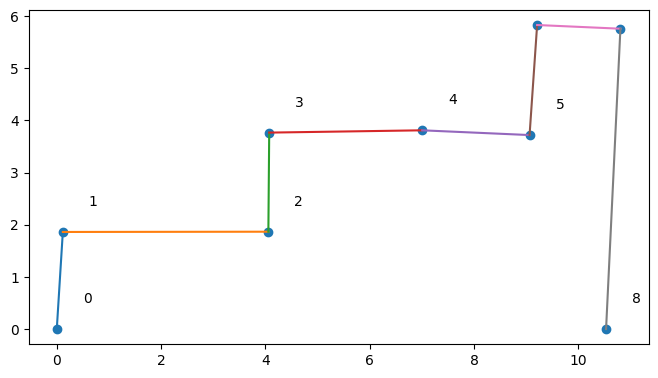

<IPython.core.display.Javascript object>

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

xv = u

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect("equal", "box")
ax.scatter(xv[:, 0], xv[:, 1])

for i, j in zip(range(len(points))[:-1], range(len(points))[1:]):
    ax.plot([xv[i, 0], xv[j, 0]], [xv[i, 1], xv[j, 1]])

for i in range(len(points)):
    ax.annotate(str(i), (xv[i, 0].item() + 0.5, xv[i, 1].item() + 0.5))